# Part 1

## Setup

In [1]:
using Plots
using JuMP, HiGHS

include("utils.jl")

sample_chain (generic function with 1 method)

In [2]:
DATA_DIR = "data/"

"data/"

In [3]:
prices = vec(read_file(DATA_DIR * "belpex_price.txt"))
states = vec(read_file(DATA_DIR * "markov_support_4.txt"))
P_prob = read_file(DATA_DIR * "markov_weights_4.txt")

4×4 Matrix{Float64}:
 0.394106    0.524075   0.0807228  0.00109546
 0.107876    0.564185   0.311323   0.016616
 0.016616    0.311323   0.564185   0.107876
 0.00109546  0.0807228  0.524075   0.394106

## Questions

### 1. Plot the evolution of the given expected price and comment. How can the battery make profit ? How is it useful for the system ?

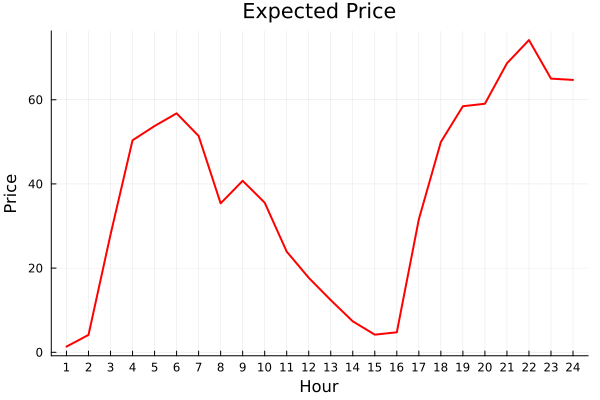

In [4]:
plot(
    1:24, 
    prices, 
    title = "Expected Price",
    xlabel = "Hour",
    ylabel = "Price",
    legend = false,
    xticks = 1:24, 
    color = :red,
    lw = 2)

### 2. Generate 10 different price scenarios over the 24 hours and plot them against the expected price.

In [5]:
N_scenarios = 10

10

In [6]:
xi_t = zeros(N_scenarios, 24)
lambda_t = zeros(N_scenarios, 24)

10×24 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [7]:
for i in 1:N_scenarios
    xi_t[i, :] = sample_chain(24, P_prob, states)
end

In [8]:
for i in 1:N_scenarios
    lambda_t[i, :] = prices .* exp.(xi_t[i, :])
end

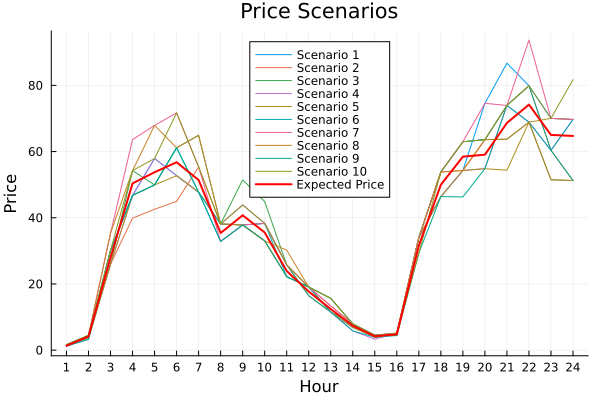

In [9]:
p = plot(
    1:24, 
    eachrow(lambda_t),
    title = "Price Scenarios",
    xlabel = "Hour",
    ylabel = "Price",
    xticks = 1:24,
    label = reshape(["Scenario $i" for i in 1:N_scenarios], 1, N_scenarios),
    legend = :top,
    )

plot!(
    1:24,
    prices, 
    label = "Expected Price",
    color = :red,
    lw = 2,
)



### 3. Formulate the deterministic problem.

The model reads :
$$
\begin{align*}
\max_{b_t, \eta_t, \xi_t}& \sum^{24}_{t=1}p_t(0.9 \eta_t - \frac{1}{0.9}\xi_t) \\
\text{s.t.}~& b_t = b_{t-1} - \eta_t + \xi_t, \quad t = 1,\dots, 24\\
&0 \leq \eta_t \leq 200,~ 0 \leq \xi_t \leq 200,\quad t = 1,\dots, 24 \\
&0 \leq b_t \leq 800,\quad t = 1,\dots, 24 \\
\end{align*}
$$
where :
* $b_t \equiv$ batery level at time $t$
* $\eta_t \equiv $ discharging at time $t$
* $\xi_t\equiv$ charging at time $t$
* $p_t\equiv $ price at time $t$

Note that the quantity of energy bought to charge $\xi_t$ MWh in the battery is $\frac{1}{0.9}\xi_t$ MWh and the quantity of energy sold when discharging $\eta_t$ MWh from the battery is then $0.9 \eta_t$ MWh

In [10]:
deterministic_model = Model(HiGHS.Optimizer)

@variable(deterministic_model, 0 <= b[1:24] <= 800)
@variable(deterministic_model, 0 <= ξ[1:24] <= 200)
@variable(deterministic_model, 0 <= η[1:24] <= 200)

@constraint(deterministic_model,[t in 2:24] ,b[t] == b[t-1] - η[t] + ξ[t])
# @constraint(deterministic_model, b[1] == 0)


@objective(deterministic_model, Max,
    sum(prices[t] * (0.9*η[t]- 1/(0.9) * ξ[t]) for t in 1:24)
)

1.215 η[1] - 1.5000000000000002 ξ[1] + 3.717 η[2] - 4.588888888888889 ξ[2] + 25.164 η[3] - 31.06666666666667 ξ[3] + 45.333 η[4] - 55.96666666666667 ξ[4] + 48.384 η[5] - 59.733333333333334 ξ[5] + 51.093 η[6] - 63.07777777777778 ξ[6] + 46.26 η[7] - 57.111111111111114 ξ[7] + 31.851000000000003 η[8] - 39.32222222222222 ξ[8] + 36.666000000000004 η[9] - 45.26666666666667 ξ[9] + 31.994999999999997 η[10] - 39.5 ξ[10] + 21.528000000000002 η[11] - 26.57777777777778 ξ[11] + 15.93 η[12] - 19.666666666666668 ξ[12] + 11.151000000000002 η[13] - 13.766666666666667 ξ[13] + 6.615 η[14] - 8.166666666666666 ξ[14] + 3.7710000000000004 η[15] - 4.655555555555556 ξ[15] + 4.275 η[16] - 5.277777777777778 ξ[16] + 28.431 η[17] - 35.1 ξ[17] + 44.964 η[18] - 55.51111111111111 ξ[18] + 52.614000000000004 η[19] - 64.95555555555556 ξ[19] + 53.144999999999996 η[20] - 65.61111111111111 ξ[20] + 61.785000000000004 η[21] - 76.27777777777779 ξ[21] + 66.76200000000001 η[22] - 82.42222222222223 ξ[22] + 58.518 η[23] - 72.244444

### 4. Solve the deterministic model of profit maximization over the 24 hours and plot the evolution of the energy stored in the battery

In [11]:
optimize!(deterministic_model)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 8e+01]
  Bound  [2e+02, 8e+02]
  RHS    [0e+00, 0e+00]
Presolving model
23 rows, 70 cols, 92 nonzeros  0s
23 rows, 70 cols, 92 nonzeros  0s
Presolve : Reductions: rows 23(-0); columns 70(-2); elements 92(-0)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         30    -8.1144466667e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 30
Objective value     :  8.1144466667e+04
HiGHS run time      :          0.00


In [12]:
bt = value.(b)
eta_t = value.(η)
xi_t = value.(ξ)

24-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 200.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

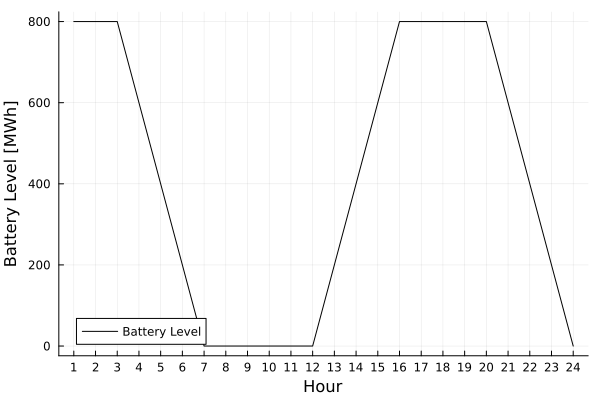

In [13]:
p = plot(
    1:24, 
    bt, 
    label="Battery Level", 
    xlabel="Hour", 
    ylabel="Battery Level [MWh]", 
    color=:black,
    xticks = 1:24,
)


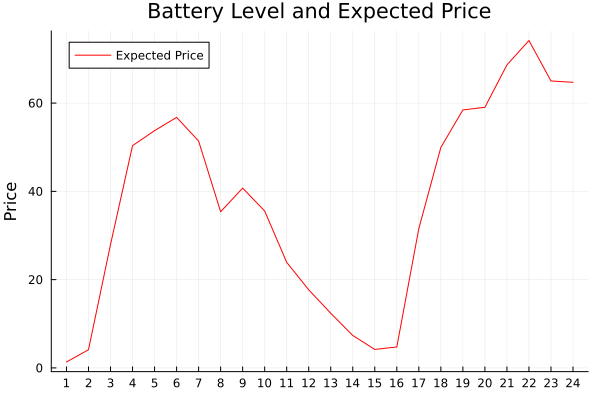

In [14]:
plot(
    1:24, 
    prices, 
    label="Expected Price", 
    ylabel = "Price", 
    color=:red,
    xticks = 1:24,
    title = "Battery Level and Expected Price"
)

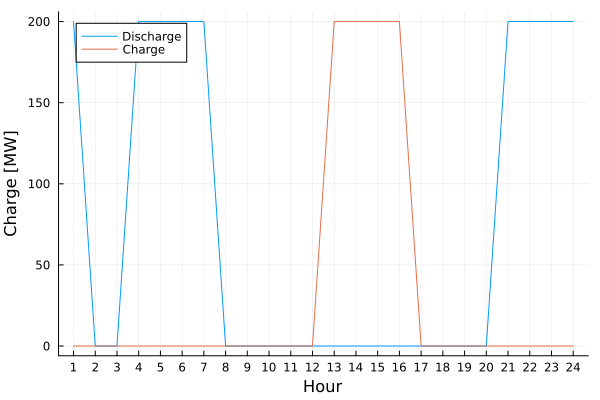

In [15]:
p = plot(
    1:24, 
    [eta_t, xi_t], 
    label = reshape(["Discharge", "Charge"], 1, 2), 
    xlabel="Hour", 
    ylabel="Charge [MW]", 
    xticks = 1:24,
)